# <font color="chillipepper">Introduction au deep learning</font>

Nous utiliserons le corpus pour ce TD `imdb`.

## Description
Le jeu de données IMDb disponible via `load_dataset('imdb')` de la bibliothèque Hugging Face Datasets contient des critiques de films provenant d'IMDb.

## Contenu
- **Nombre total de critiques** : 50 000
  - **Entraînement** : 25 000 critiques
  - **Test** : 25 000 critiques

## Étiquettes
- Chaque critique est étiquetée comme :
  - **Positive**
  - **Négative**

## Format
- Les critiques sont fournies sous forme de texte brut.

Nous allons entrainer et comparer 2 modèles de classification de texte en utilisant 2 méthodes différentes.

In [ ]:
#!pip install datasets
#!pip install torchinfo

## librairies

In [ ]:
import torch
from datasets import load_dataset
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="dark")

## Données

In [ ]:
data = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
data.set_format(type="pandas")
df = data["train"][:]
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [ ]:
test_df = data["test"][:]
test_df.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


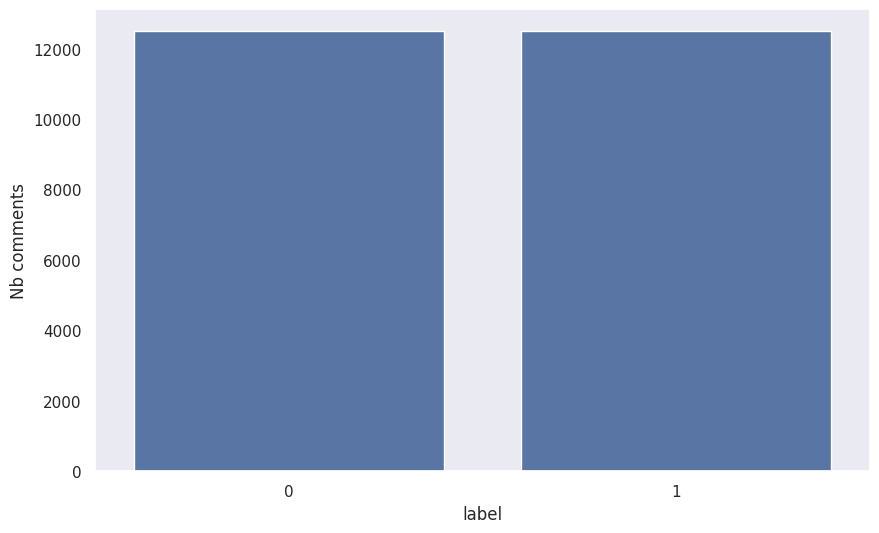

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="label", order=df["label"].value_counts().index)
plt.ylabel("Nb comments")
plt.show()

Nous avons autant de commentaires positifs que négatifs.

In [ ]:
# Calcul du nombre de mots par commentaire
df["Words Per comment"] = df["text"].str.split().apply(len)

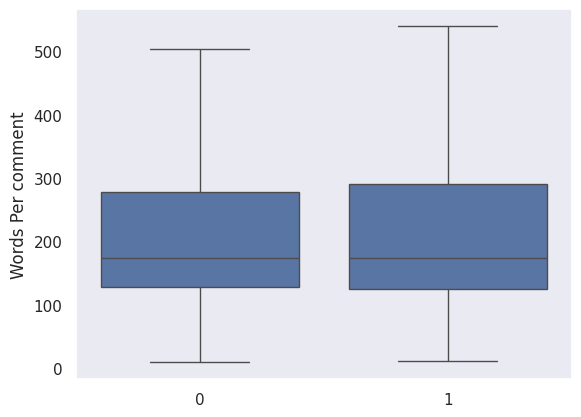

In [ ]:
sns.boxplot(data=df, x="label", y="Words Per comment", showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

Les commentaires ont autour de 180 mots pour chaque type de sentiment. Les plus longs ne pourront pas être pris en compte par le tokenizer car étant supérieurs à la longueur maximale acceptée. Il seront donc coupés.

In [ ]:
data.reset_format()

## Tokenizer

In [ ]:
BATCH_SIZE = 16

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
tokenizer(["Bonjour, comment vas-tu ?"], )

{'input_ids': [[101, 14753, 23099, 2099, 1010, 7615, 12436, 2015, 1011, 10722, 1029, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

## DataHandler

Let's create a datahandler.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
data['train'][1]["text"]

'"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the s

In [ ]:
class IMDbDataset(Dataset):
    def __init__(self,data, tokenizer, max_length: int=512):
        self.dataset = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Permet de faire des paquets de données et de les rendre sous un format itérable
def create_data_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_dataset = IMDbDataset(data['train'], tokenizer)
test_dataset = IMDbDataset(data['test'], tokenizer)

In [ ]:
train_dataset[0]

{'input_ids': tensor([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,  2026,
          2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,
          2043,  2009,  2001,  2034,  2207,  1999,  3476,  1012,  1045,  2036,
          2657,  2008,  2012,  2034,  2009,  2001,  8243,  2011,  1057,  1012,
          1055,  1012,  8205,  2065,  2009,  2412,  2699,  2000,  4607,  2023,
          2406,  1010,  3568,  2108,  1037,  5470,  1997,  3152,  2641,  1000,
          6801,  1000,  1045,  2428,  2018,  2000,  2156,  2023,  2005,  2870,
          1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,  1996,
          5436,  2003,  8857,  2105,  1037,  2402,  4467,  3689,  3076,  2315,
         14229,  2040,  4122,  2000,  4553,  2673,  2016,  2064,  2055,  2166,
          1012,  1999,  3327,  2016,  4122,  2000,  3579,  2014,  3086,  2015,
          2000,  2437,  2070,  4066,  1997,  4516,  2006,  2054,  1996,  2779,
         25430, 14728,  2245,  2055,  3

In [ ]:
train_data_loader = create_data_loader(train_dataset, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset, BATCH_SIZE)

## <font color="chillipepper">Modèle Pytorch </font>

Notre objectif est de définir un modèle d'apprentissage profond, de l'entraîner, de faire des prédictions avec et de l'évaluer.

Avec PyTorch, cela signifie faire les trois "scripts" suivants :

1. **Définir le modèle**
2. **Implémenter la prédiction**
3. **Implémenter la boucle d'entraînement**
    - Définir une fonction de perte
    - Définir un optimiseur
    - Boucle :
        - Passage avant (forward pass)
        - Passage arrière (backward pass)
        - Appliquer la règle de mise à jour de l'optimisation
4. **Évaluer le modèle / jouer avec**
    - Vous pouvez utiliser le critère d'entraînement (perte) comme score d'évaluation
    - Vous pouvez utiliser un autre score : précision (accuracy), F1

### <font color="chillipepper">1. Definissons le modèle</font>

Les modèles PyTorch suivent toujours le même modèle :

- une classe
- définition de toutes les couches (ou paramètres) dans `__init__()`
- définition du passage avant dans `forward()`

Voyons à quoi cela ressemble avec un modèle simple à 2 couches.

Toutes les couches triviales de réseaux neuronaux peuvent généralement être trouvées dans torch.nn.

**Attention** : Tous vos modules paramétrés (couches ou vecteurs entraînables) doivent être définis comme des attributs *directs* de votre classe ```nn.Module``` afin que l'appel à ```.backward()``` puisse correctement propager les gradients à travers tout. Pour définir des couches dans un attribut de liste (resp. attributs de dictionnaire), utilisez ```ModuleList``` (resp. ```ModuleDict```).

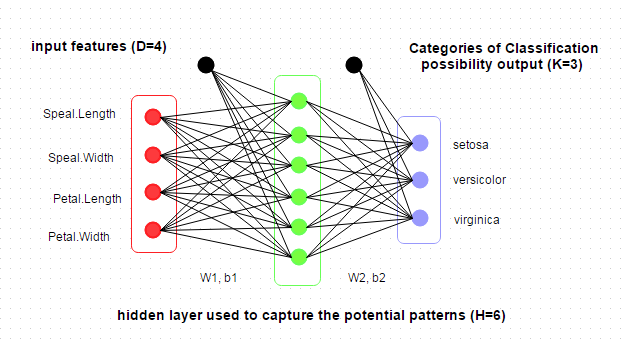


In [ ]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import torch.nn as nn
from torchinfo import summary

In [ ]:


class MinimalExampleModel(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        Dans le constructeur, nous instancions deux modules nn.Linear et les assignons
        comme variables membres.
        """
        super(MinimalExampleModel, self).__init__()
        # définir une première couche linéaire avec une dimension d'entrée (D_in) et une dimension cachée (H)
        # documentation de la couche linéaire : https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        self.linear1 = nn.Linear(D_in, H, bias=True)
        # définir la couche linéaire finale, souvent appelée couche de classification car la dimension de sortie (D_out) == le nombre de classes cibles
        self.linear2 = nn.Linear(H, D_out, bias=True)

    def forward(self, x):
        """
        Dans la fonction forward, nous acceptons un tenseur de données d'entrée et nous devons retourner
        un tenseur de données de sortie. Nous pouvons utiliser les modules définis dans le constructeur ainsi que des opérateurs arbitraires sur les tenseurs.
        """
        # appliquer d'abord la couche linear1 sur le vecteur et l'encapsuler avec une fonction d'activation pour la non-linéarisation. Cela crée une couche dense.
        # documentation de relu : https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        h_relu = torch.relu(self.linear1(x))
        y_pred = self.linear2(h_relu)
        return y_pred

### <font color="chillipepper">2. Forward pass</font>
1. Initialiser le modèle
2. mettre des données en entrée
3. calculer la foward pass

In [ ]:
# instanciating the model with
# N:      batch size
# D_in:   input dimension
# H:      hidden dimension
# D_out:  output dimension
N, D_in, H, D_out = 2, 10, 10, 2


# Note: tous les paramètres sont initialisés ici
model = MinimalExampleModel(D_in, H, D_out)
# visualisons le contenu
model

MinimalExampleModel(
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
# utilisons torch infos pour mieux comprendre le contenu du modèle: https://github.com/TylerYep/torchinfo

dummy_input_size = (1, 10) # (batch_size, D_in)
summary(model, (N, D_in))

Layer (type:depth-idx)                   Output Shape              Param #
MinimalExampleModel                      [2, 2]                    --
├─Linear: 1-1                            [2, 10]                   110
├─Linear: 1-2                            [2, 2]                    22
Total params: 132
Trainable params: 132
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
# Avant de passer à l'entrainement, faisons un test rapide de notre modèle
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# vérifier si un accélerateur est disponible
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
model = model.to(device)

#model = MyModel(D_in, H, D_out)
# forward pass / predict x
y_pred = model(x.to(device)) # almost equivalent to model.forward(x)
# y_pred
y_pred

DEVICE =  CPU


tensor([[ 0.3060, -0.0449],
        [ 0.1256,  0.2465]], grad_fn=<AddmmBackward0>)

### <font color="chillipepper">3. Notre premier modèle de classification</font>

In [ ]:
class TweetModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim, output_dim, embed_dim):
        """
        Dans le constructeur, nous instancions deux modules nn.Linear et les assignons
        comme variables membres.
        """
        super(TweetModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.hidden_linear_layer = nn.Linear(embed_dim, hidden_dim, bias=True)
        self.classification_layer = nn.Linear(hidden_dim, output_dim, bias=True)
        # couche softmax pour calculer les probabilités des classes
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Dans la fonction forward, nous acceptons un tenseur de données d'entrée et nous devons retourner
        un tenseur de données de sortie. Nous pouvons utiliser les modules définis dans le constructeur ainsi que des opérateurs arbitraires sur les tenseurs.
        """
        # appliquer les embeddings pré-entraînés
        x = self.embedding(x)
        x = x.mean(1)
        h = torch.relu(self.hidden_linear_layer(x))
        h = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [ ]:
vocab_size = tokenizer.vocab_size
embed_dim = 128
hidden_dim = 128
output_dim = 2
lr = 2e-5
n_epoch = 5

model = TweetModel(vocab_size, embed_dim, hidden_dim, output_dim)

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=lr)
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
loss_fn = CrossEntropyLoss()


### <font color="chillipepper">4. Boucle d'entraînement </font>

- **Critère** :

Un modèle est entraîné par rapport à un _critère d'entraînement_ ou une _perte_.   
PyTorch fournit de nombreuses pertes pré-codées différentes :
    - Erreur quadratique moyenne (Mean-Square Error)
    - Entropie croisée catégorielle (Categorical Cross-Entropy), ...

La plupart d'entre elles peuvent être trouvées dans torch.nn.

- **Optimiseur** :

Dans PyTorch, comme dans tout framework d'apprentissage profond (par exemple TensorFlow), les modèles sont entraînés avec la rétropropagation. La rétropropagation consiste à appliquer la descente de gradient stochastique (SGD) à un réseau de neurones. Il existe une large gamme de variantes autour de la forme simple de la SGD.

PyTorch fournit des objets prédéfinis pour de nombreuses formes différentes d'algorithmes de descente de gradient dans torch.optim :
- SGD
- Adadelta
- Adam

Dans ce notebook, nous utilisons ce dernier, en raison de sa convergence généralement plus rapide.

Votre optimiseur sera instancié avec sa configuration (par exemple, le *step_size* ou *learning_rate* pour SGD), et les paramètres du réseau.

Aperçu de tous les algorithmes basés sur la descente de gradient : https://ruder.io/optimizing-gradient-descent/

- **Boucle d'entraînement** :
    - Passage avant (forward pass) pour obtenir la prédiction et la valeur de la perte
    - `zero_grad` : Réinitialiser la valeur du gradient à zéro pour tous les paramètres avant d'ajouter leurs nouvelles valeurs rétropropagées (cette étape est cruciale !)
    - Calculer la valeur des gradients avec `loss.backward()`
    - Mettre à jour tous les paramètres du modèle avec `optimizer.step()`

L'ordre de ces étapes ne doit **PAS** être modifié !

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d['input_ids'].to(device) # Le modèle et les données doivent être au même accélerateur
        attention_mask = d['attention_mask'].to(device)
        labels = d['label'].to(device)

        outputs = model(input_ids)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
for epoch in range(n_epoch):
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        len(train_dataset)
    )
    print(f'Epoch {epoch + 1}/{n_epoch}')
    print(f'Train loss {train_loss} accuracy {train_acc}')

100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]


Epoch 1/5
Train loss 4.82103646815929 accuracy 0.41016


100%|██████████| 1563/1563 [01:00<00:00, 25.85it/s]


Epoch 2/5
Train loss 4.53238438980288 accuracy 0.49976


100%|██████████| 1563/1563 [00:59<00:00, 26.17it/s]


Epoch 3/5
Train loss 4.394180465644548 accuracy 0.49988


100%|██████████| 1563/1563 [00:58<00:00, 26.78it/s]


Epoch 4/5
Train loss 4.373527189744106 accuracy 0.50004


100%|██████████| 1563/1563 [00:58<00:00, 26.79it/s]

Epoch 5/5
Train loss 4.367134138474614 accuracy 0.50004


### <font color="chillipepper">4. Evaluation du modèle </font>

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['label'].to(device)

            outputs = model(input_ids)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return accuracy_score(real_values, predictions)

In [ ]:
test_accuracy = evaluate_model(model, test_data_loader, device)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.49996


### <font color="chillipepper">5. Améliorons les résultats </font>

Un modèle aléaatoire fait mieux que le modèle précédent. Nous allons utiliser un modèle pré-entrainer pour améliorer ces résultats.

Pour ce faire, nous allons utiliser les classes de huggingface pour effectuer l'entrainement.

In [ ]:
from transformers import AutoModelForSequenceClassification
# Initialisation du modèle
num_labels = 2
model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Tokenize the dataset
tokenized_dataset = data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset["train"].column_names)


['text', 'label', 'input_ids', 'attention_mask']


In [ ]:

from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-imdb"
training_args = TrainingArguments(
                                  output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error",
                                  save_strategy="no",
                                report_to="none")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset["train"],
                  eval_dataset=tokenized_dataset["test"],
                  tokenizer=tokenizer,
                  )

<ipython-input-41-9acbcfa20f0c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [ ]:
trainer.train();

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


In [ ]:
preds_output = trainer.predict(tokenized_dataset["test"])

preds_output.metrics